
# **Object Detection on a Custom Dataset using YOLO v5**

In [ ]:
!nvidia-smi

In [2]:
!sudo apt-get install tree -qq > /dev/null

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


## **Prerequisites**

In [1]:
!pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install numpy==1.17
!pip install PyYAML==5.3.1
!pip install git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-8spppt84
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-8spppt84
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266455 sha256=1b8bf413ab055cce4330865ea6f4081a334ee48aa12a19b9c2e28fd9d1a1e59c
  Stored in directory: /tmp/pip-ephem-wheel-cache-f231wil4/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools


In [2]:
!git clone https://github.com/NVIDIA/apex && cd apex && pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" . --user && cd .. && rm -rf apex

Cloning into 'apex'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 7456 (delta 0), reused 0 (delta 0), pack-reused 7455
Receiving objects: 100% (7456/7456), 13.91 MiB | 27.82 MiB/s, done.
Resolving deltas: 100% (5038/5038), done.
/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-87lnm0bz
Created temporary directory: /tmp/pip-req-tracker-8vlcy44_
Created requirements tracker '/tmp/pip-req-tracker-8vlcy44_'
Created temporary directory: /tmp/pip-install-ljiqd1x9
Processing /content/apex
  Created temporary directory: /tmp/pip-req-build-fe7g6h6a
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-8vlcy44_'
    Running setup.py (path:/tmp/pip-req-build-fe7g6h6a/setup.py) egg_info 

## **Build a dataset**

In [3]:
!gdown --id 1uWdQ2kn25RSQITtBHa9_zayplm27IXNC

Downloading...
From: https://drive.google.com/uc?id=1uWdQ2kn25RSQITtBHa9_zayplm27IXNC
To: /content/clothing.json
100% 199k/199k [00:00<00:00, 6.52MB/s]


In [4]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import json
import urllib
import PIL.Image as Image
import cv2
import torch
import torchvision
from IPython.display import display
from sklearn.model_selection import train_test_split

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10

np.random.seed(42)

In [5]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [6]:
clothing = []
with open("/gdrive/My Drive/Colab Notebooks/data/clothing.json") as f:
    for line in f:
        clothing.append(json.loads(line))

In [7]:
clothing[0]

{'annotation': [{'imageHeight': 312,
   'imageWidth': 147,
   'label': ['Tops'],
   'notes': '',
   'points': [{'x': 0.02040816326530612, 'y': 0.2532051282051282},
    {'x': 0.9931972789115646, 'y': 0.8108974358974359}]}],
 'content': 'http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb063ad2b650163b00a1ead0017/4bb8fd9d-8d52-46c7-aa2a-9c18af10aed6___Data_xxl-top-4437-jolliy-original-imaekasxahykhd3t.jpeg',
 'extras': None}

In [8]:
for c in clothing:
  if len(c['annotation']) > 1:
    display(c)

{'annotation': [{'imageHeight': 312,
   'imageWidth': 265,
   'label': ['Jackets'],
   'notes': '',
   'points': [{'x': 0, 'y': 0.6185897435897436},
    {'x': 0.026415094339622643, 'y': 0.6185897435897436}]},
  {'imageHeight': 312,
   'imageWidth': 265,
   'label': ['Skirts'],
   'notes': '',
   'points': [{'x': 0.01509433962264151, 'y': 0.03205128205128205},
    {'x': 1, 'y': 0.9839743589743589}]}],
 'content': 'http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb063ad2b650163b00a1ead0017/b3be330c-c211-45bb-b244-11aef08021c8___Data_free-sk-5108-mudrika-original-imaf4fz626pegq9f.jpeg',
 'extras': None}

In [9]:
categories = []
for c in clothing:
  for a in c['annotation']:
    categories.extend(a['label'])
categories = list(set(categories))
categories.sort()
categories

['Jackets',
 'Jeans',
 'Shirts',
 'Shoes',
 'Skirts',
 'Tops',
 'Trousers',
 'Tshirts',
 'sunglasses']

In [10]:
train_clothing, val_clothing = train_test_split(clothing, test_size=0.1)
len(train_clothing), len(val_clothing)

(453, 51)

## **Sample image and annotation**

In [11]:
row = train_clothing[10]

img = urllib.request.urlopen(row["content"])
img = Image.open(img)
img = img.convert('RGB')

img.save("demo_image.jpeg", "JPEG")
img = cv2.cvtColor(cv2.imread(f'demo_image.jpeg'), cv2.COLOR_BGR2RGB)
img.shape

(312, 145, 3)

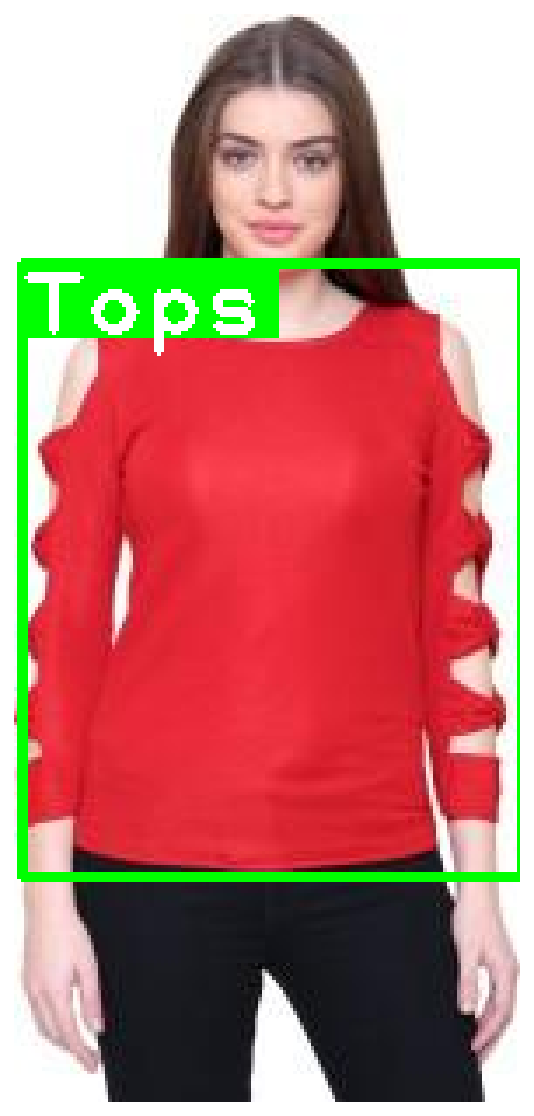

In [12]:
for a in row['annotation']:
  for label in a['label']:

    w = a['imageWidth']
    h = a['imageHeight']

    points = a['points']
    p1, p2 = points

    x1, y1 = p1['x'] * w, p1['y'] * h
    x2, y2 = p2['x'] * w, p2['y'] * h

    cv2.rectangle(
      img,
      (int(x1), int(y1)),
      (int(x2), int(y2)),
      color=(0, 255, 0),
      thickness=2
    )

    ((label_width, label_height), _) = cv2.getTextSize(
        label, 
        fontFace=cv2.FONT_HERSHEY_PLAIN,
        fontScale=1.75, 
        thickness=2
    )

    cv2.rectangle(
      img,
      (int(x1), int(y1)),
      (int(x1 + label_width + label_width * 0.05), int(y1 + label_height + label_height * 0.25)),
      color=(0, 255, 0),
      thickness=cv2.FILLED
    )

    cv2.putText(
      img,
      label,
      org=(int(x1), int(y1 + label_height + label_height * 0.25)), # bottom left
      fontFace=cv2.FONT_HERSHEY_PLAIN,
      fontScale=1.75,
      color=(255, 255, 255),
      thickness=2
    )
plt.imshow(img)
plt.axis('off');

## **Convert to YOLO format**

In [13]:
def create_dataset(clothing, categories, dataset_type):

  images_path = Path(f"clothing/images/{dataset_type}")
  images_path.mkdir(parents=True, exist_ok=True)

  labels_path = Path(f"clothing/labels/{dataset_type}")
  labels_path.mkdir(parents=True, exist_ok=True)

  for img_id, row in enumerate(tqdm(clothing)):

    image_name = f"{img_id}.jpeg"

    img = urllib.request.urlopen(row["content"])
    img = Image.open(img)
    img = img.convert("RGB")

    img.save(str(images_path / image_name), "JPEG")

    label_name = f"{img_id}.txt"

    with (labels_path / label_name).open(mode="w") as label_file:

      for a in row['annotation']:

        for label in a['label']:

          category_idx = categories.index(label)

          points = a['points']
          p1, p2 = points

          x1, y1 = p1['x'], p1['y']
          x2, y2 = p2['x'], p2['y']

          bbox_width = x2 - x1
          bbox_height = y2 - y1

          label_file.write(
            f"{category_idx} {x1 + bbox_width / 2} {y1 + bbox_height / 2} {bbox_width} {bbox_height}\n"
          )

In [14]:
create_dataset(train_clothing, categories, 'train')
create_dataset(val_clothing, categories, 'val')

100%|██████████| 51/51 [00:02<00:00, 21.51it/s]


## **Fine-tuning YOLO v5**

In [15]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!git checkout ec72eea62bf5bb86b0272f2e65e413957533507f

fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5
M	models/yolov5x.yaml
HEAD is now at ec72eea Merge remote-tracking branch 'origin/master'


In [16]:
!gdown --id 1ZycPS5Ft_0vlfgHnLsfvZPhcH6qOAqBO -O data/clothing.yaml
!gdown --id 1czESPsKbOWZF7_PkCcvRfTiUUJfpx12i -O models/yolov5x.yaml

Downloading...
From: https://drive.google.com/uc?id=1ZycPS5Ft_0vlfgHnLsfvZPhcH6qOAqBO
To: /content/yolov5/data/clothing.yaml
100% 172/172 [00:00<00:00, 267kB/s]
Downloading...
From: https://drive.google.com/uc?id=1czESPsKbOWZF7_PkCcvRfTiUUJfpx12i
To: /content/yolov5/models/yolov5x.yaml
100% 1.58k/1.58k [00:00<00:00, 1.42MB/s]


## **Training**

In [18]:
!python train.py --img 640 --batch 4 --epochs 30 \
  --data ./data/clothing.yaml --cfg ./models/yolov5x.yaml --weights yolov5x.pt \
  --name yolov5x_clothing --cache

{'lr0': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'giou': 0.05, 'cls': 0.58, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0.0, 'hsv_h': 0.014, 'hsv_s': 0.68, 'hsv_v': 0.36, 'degrees': 0.0, 'translate': 0.0, 'scale': 0.5, 'shear': 0.0}
Namespace(adam=False, batch_size=4, bucket='', cache_images=True, cfg='./models/yolov5x.yaml', data='./data/clothing.yaml', device='', epochs=30, evolve=False, img_size=[640], multi_scale=False, name='yolov5x_clothing', noautoanchor=False, nosave=False, notest=False, rect=False, resume=False, single_cls=False, weights='yolov5x.pt')
Using CUDA Apex device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

2020-11-08 19:06:35.188870: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Start Tensorboard with "tensorboard --logdir=runs", view at http://localhost:6006/

              from  n    params  module                             

## **Evaluation**

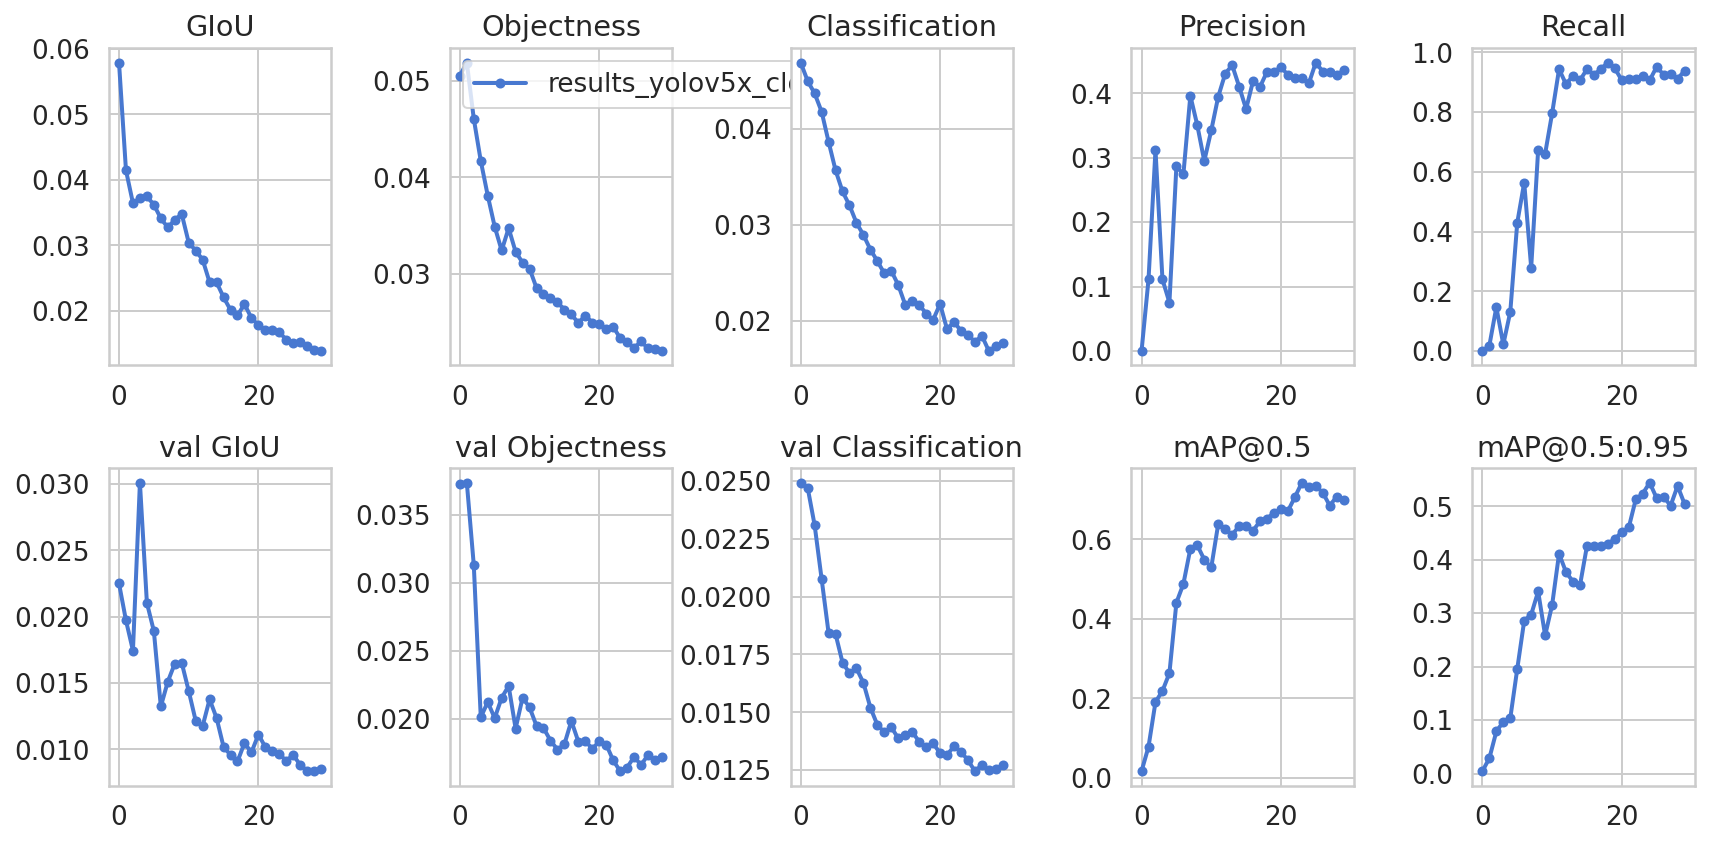

In [19]:
from utils.utils import plot_results

plot_results();

## **Making predictions**

In [20]:
!find ../clothing/images/val/ -maxdepth 1 -type f | head -50 | xargs cp -t "./inference/images/"

!python detect.py --weights weights/best_yolov5x_clothing.pt \
  --img 640 --conf 0.4 --source ./inference/images/

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', fourcc='mp4v', img_size=640, iou_thres=0.5, output='inference/output', save_txt=False, source='./inference/images/', view_img=False, weights='weights/best_yolov5x_clothing.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

image 1/52 inference/images/0.jpeg: 320x640 1 sunglassess, Done. (0.037s)
image 2/52 inference/images/1.jpeg: 640x320 1 Skirtss, Done. (0.039s)
image 3/52 inference/images/10.jpeg: 640x448 Done. (0.044s)
image 4/52 inference/images/11.jpeg: 640x384 Done. (0.023s)
image 5/52 inference/images/12.jpeg: 640x256 1 Skirtss, Done. (0.021s)
image 6/52 inference/images/13.jpeg: 640x384 Done. (0.023s)
image 7/52 inference/images/14.jpeg: 640x512 Done. (0.026s)
image 8/52 inference/images/15.jpeg: 640x512 Done. (0.025s)
image 9/52 inference/images/16.jpeg: 640x320 Done. (0.021s)
image 10/52 inference/images/17.jpeg: 640x512 1 Jeanss, 1 Trouserss, Done. (0.029

In [21]:
def load_image(img_path: Path, resize=True):
  img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (128, 256), interpolation = cv2.INTER_AREA)
  return img

def show_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

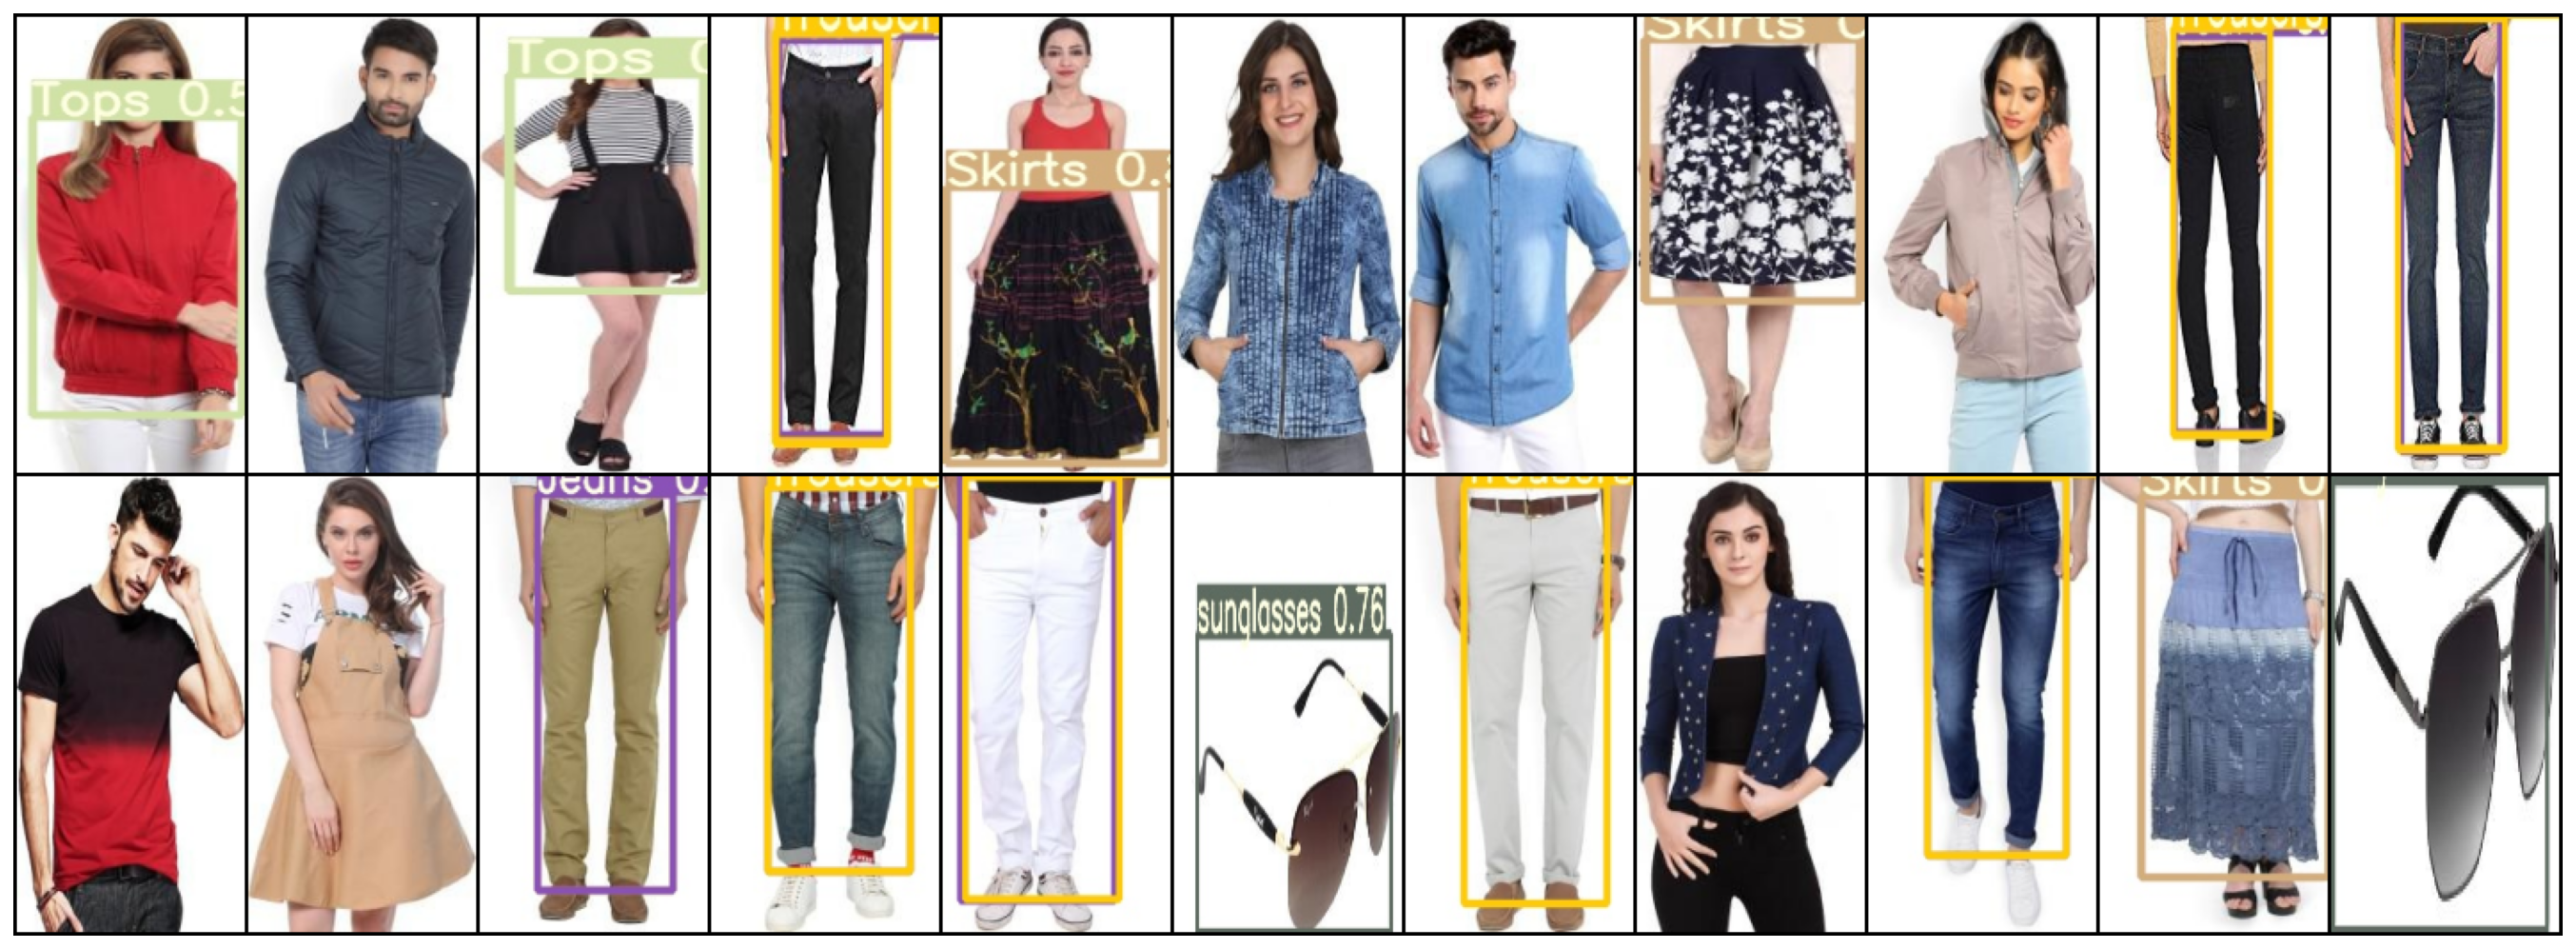

In [22]:
img_paths = list(Path("inference/output").glob("*.jpeg"))[:22]
show_grid(img_paths)